In [1]:
import sys
sys.path.append('/home/monte.flora/python_packages/master/ml_workflow')

In [2]:
import pickle
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
from  joblib import load
from matplotlib.colors import ListedColormap
from scipy.stats import gaussian_kde
import scipy
from scipy import interpolate
import itertools

from os.path import join
from glob import glob

from metrics import norm_aupdc
from bootstrapper import data_iterator, data_iterator_2d
from plotter import pretty_plot

from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
from scipy.ndimage import gaussian_filter


import seaborn as sns
sns.set_theme()

## USER DEFINED VARIABLES

In [3]:
# User-defined variables
target = 'severe_hail'
lead_time = 'first_hour'
n_bootstrap=5

#------------------------------------
# THE ORIGINAL TESTING DATASETS HAVE THE UNCALIBRATED BASELINE PREDICTIONS. 
# NEED TO COMPUTE THEM AND STORE THEM USING THE NAMES DIRECTLY BELOW. 
# SHOULD ALSO SWITCH OVER FEATHER DATASETS STYLE. 
#------------------------------------
baseline_names = {
                'tornado': 'Baseline__tornado', 
                 'severe_hail' : 'Baseline__severe_hail',
                'severe_wind' : 'Baseline__severe_wind',
}

known_skew = {'first_hour': {'severe_hail': 0.0391880873707248,
  'severe_wind': 0.027375770765324627,
  'tornado': 0.012250931885049705},
 'second_hour': {'severe_hail': 0.03567197119293762,
  'severe_wind': 0.02379619369012823,
  'tornado': 0.009605216107852312}}

## Loading testing data

In [4]:
path = '/work/mflora/ML_DATA/test_data'
test_df = pd.read_feather(join(path, f'test_ml_dataset_{lead_time}_{target}.feather'))
init_times = test_df['Run Time']
test_dates = test_df['Run Date']

## Load ML model

In [5]:
# Just to keep the filename on a single line. 
fname_filler = '_under_standard__.pkl'
model_fname = glob(join('/work/mflora/ML_DATA/MODEL_SAVES', f'LogisticRegression_{lead_time}_{target}*'))
model_fname = [f for f in model_fname if 'manual' not in f][0]

data = load(model_fname)
original_features = data['features']
model = data['model']

X = test_df[original_features]
y = test_df[f'matched_to_{target}_0km'].values

/home/monte.flora/miniconda3/envs/wofs_test/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator SimpleImputer from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/monte.flora/miniconda3/envs/wofs_test/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/monte.flora/miniconda3/envs/wofs_test/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LogisticRegression from vers

## Compute the forecast probabilities 

In [6]:
# Compute the ML predictions
ml_predictions = model.predict_proba(X)[:,1]
bl_predictions = test_df[baseline_names[target]].values

In [7]:
norm_aupdc(y, ml_predictions, known_skew=known_skew[lead_time][target])

0.424893468818083

In [8]:
norm_aupdc(y, bl_predictions, known_skew=known_skew[lead_time][target])

0.3200103403484532

## Single Variable Stratification 

In [9]:
# Get the bin edges. 
variable = X['shear_u_0to6_ens_mean_spatial_mean'].values
n_bins = 5
#This will create bins based on the 0-25, 25-50, 50-75, 75-100 percentile bins 
left_edges = np.unique(np.percentile(variable, np.linspace(0, 100., n_bins)[:-1],interpolation="lower",))

# Bin up the data into bins by the left edge
var_bin_indices = np.digitize(variable, bins=left_edges, right=False)
iterator = np.unique(var_bin_indices)

ml_ds, bl_ds = data_iterator(to_be_stratified=var_bin_indices, 
                             iterator=iterator,
                             ml_predictions=ml_predictions,
                             bl_predictions=bl_predictions,
                             forecast_time_indices = test_df['FCST_TIME_IDX'].astype(int),
                             X=test_df,
                             y=y,
                             known_skew=known_skew[lead_time][target],
                             n_bootstrap=n_bootstrap,
                            )

Text(0.5, 0.98, 'SEVERE HAIL FIRST HOUR')

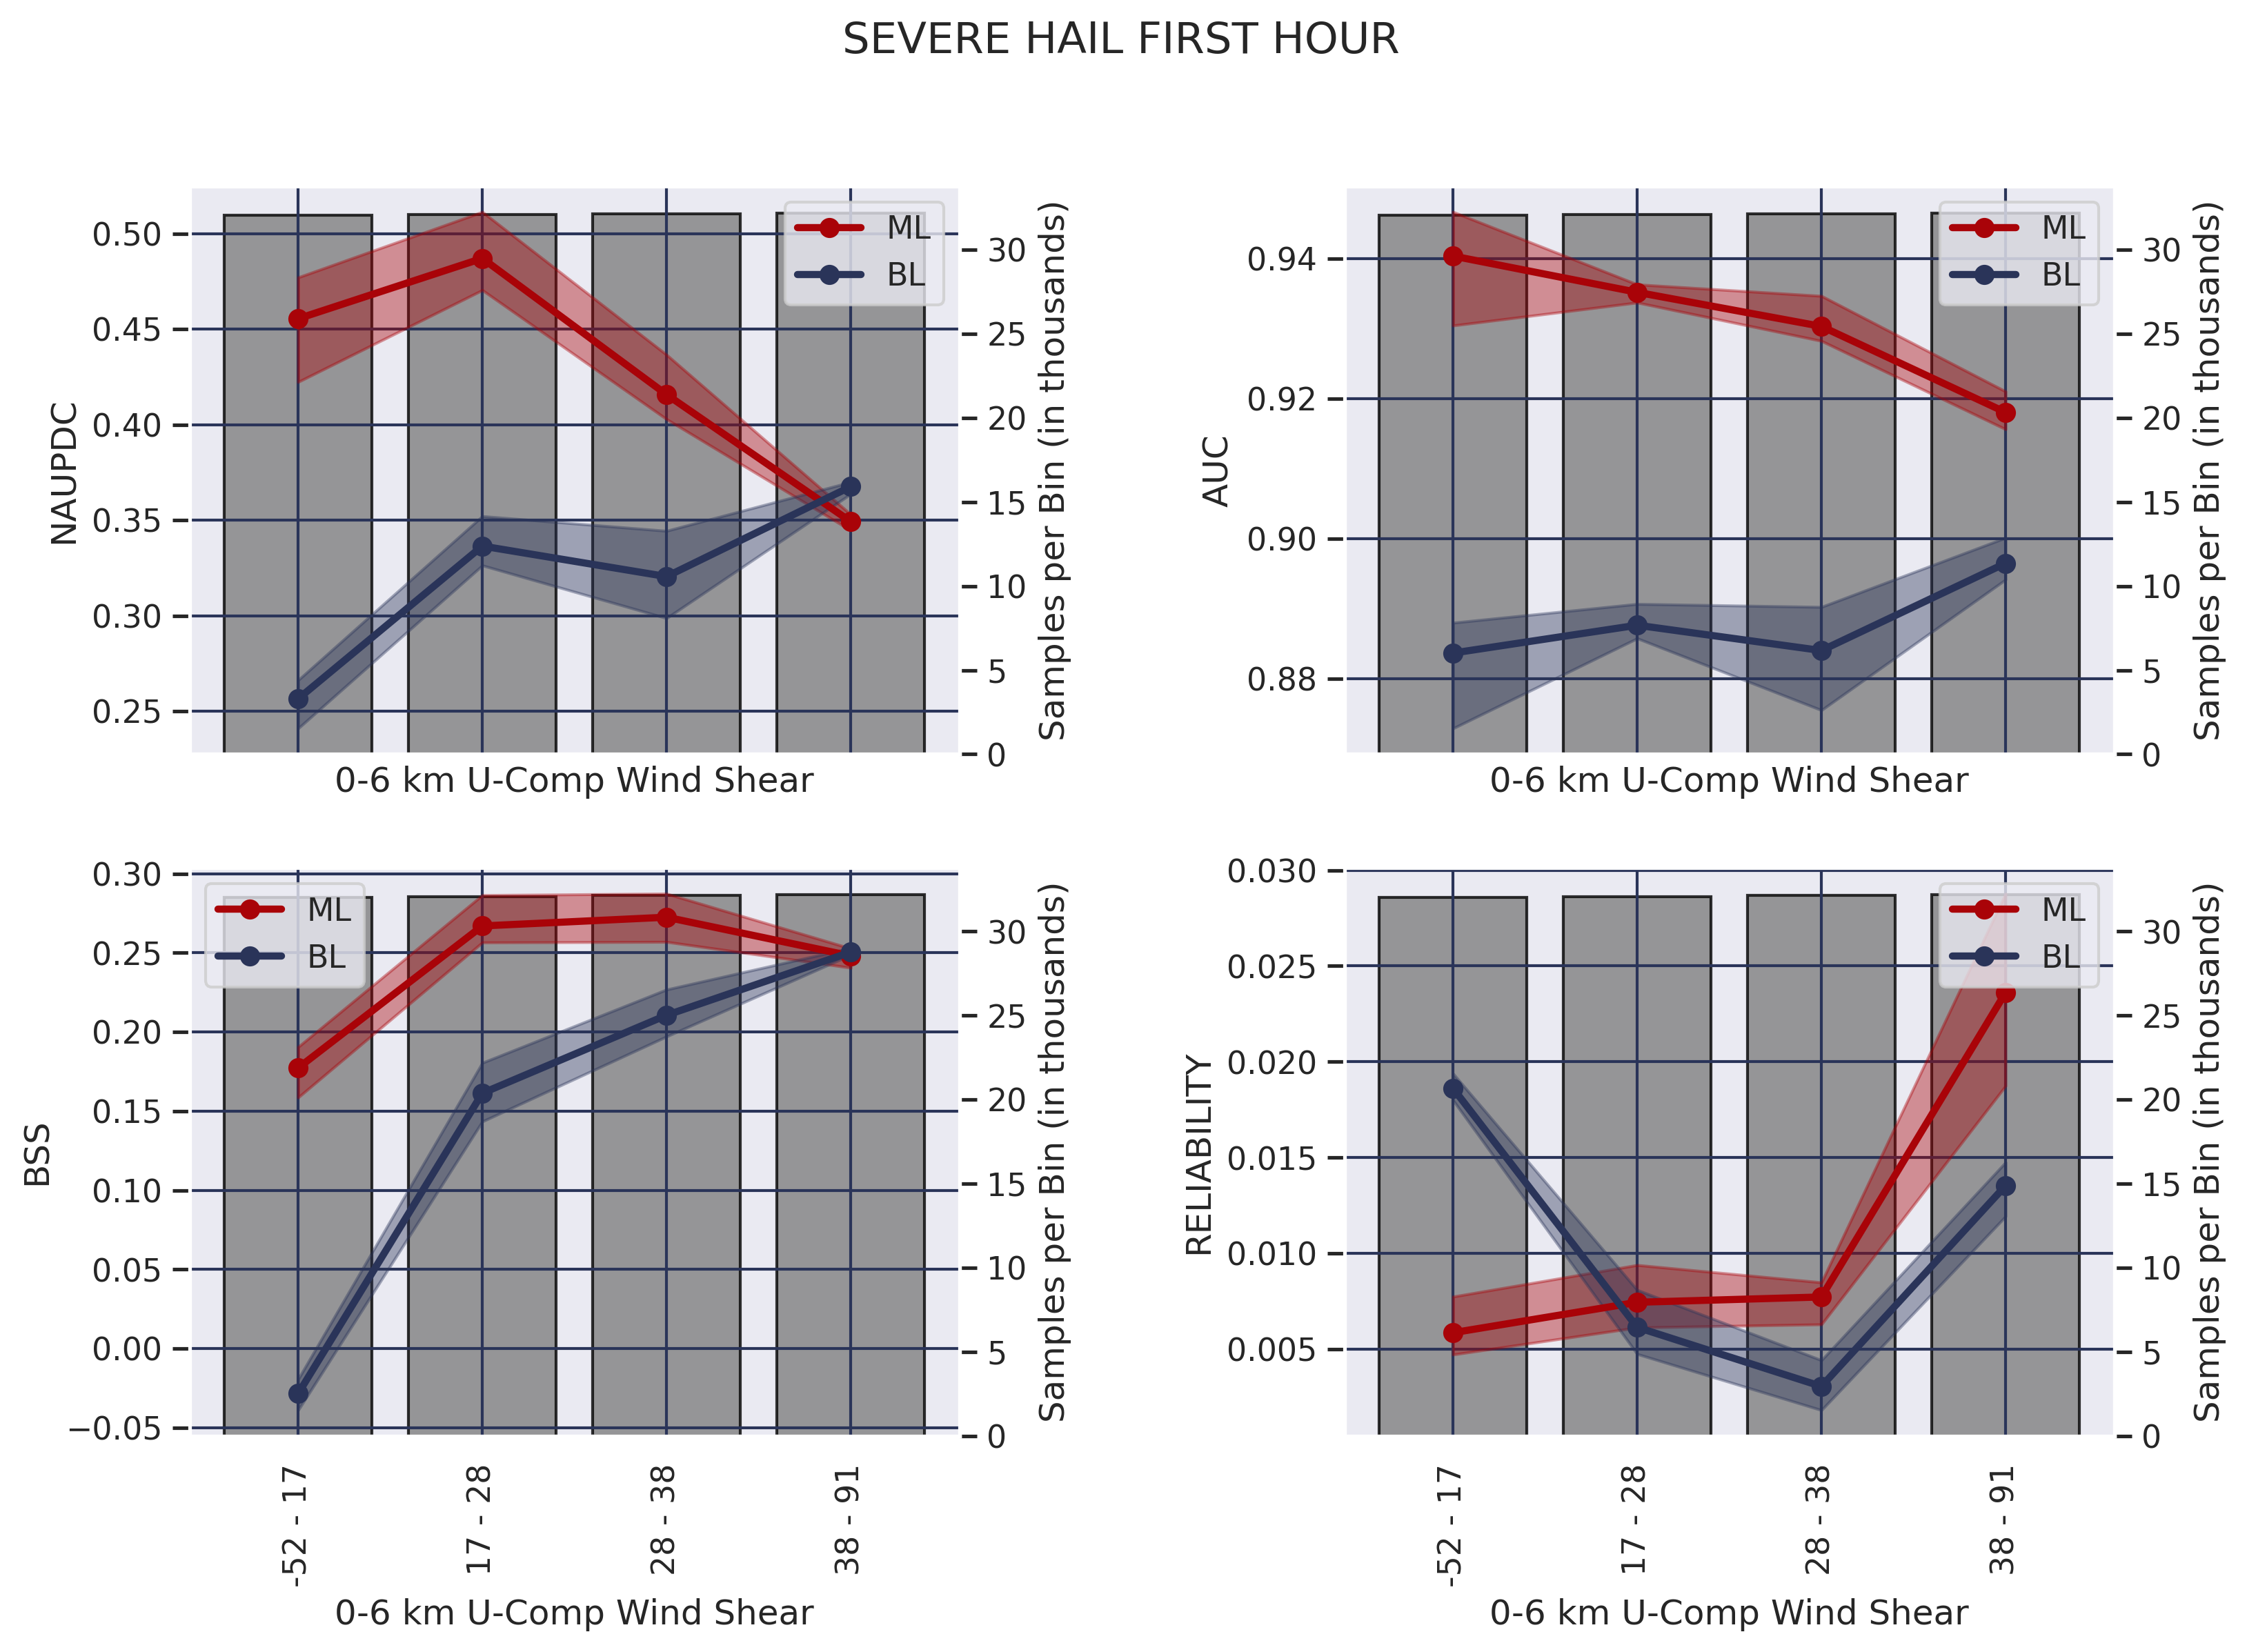

In [10]:
f,axes=plt.subplots(ncols=2, nrows=2, dpi=300, figsize=(12,8), sharex=True)
metrics = ['naupdc', 'auc', 'bss', 'reliability']
xdata = [0.5+i for i in range(n_bins-1)]
for ax, metric in zip(axes.flat, metrics):
    data = {'ML' : ml_ds[metric], 'BL' : bl_ds[metric]}
    
    pretty_plot(ax, xdata, data, 
                histdata=np.mean(ml_ds['Counts'].values, axis=1).astype(int)/1000, 
                hist_xdata = list(left_edges) + [np.max(variable)],
                xlabel='0-6 km U-Comp Wind Shear', 
                ylabel=metric.upper(), 
                right_ylabel = 'Samples per Bin (in thousands)',
                model_name='', 
             )
    
plt.subplots_adjust(wspace=0.5, hspace=0.2)
plt.suptitle(f"{target.replace('_', ' ').upper()} {lead_time.replace('_', ' ').upper()}", fontsize=15)

Text(0.5, 0.98, 'SEVERE HAIL FIRST HOUR')

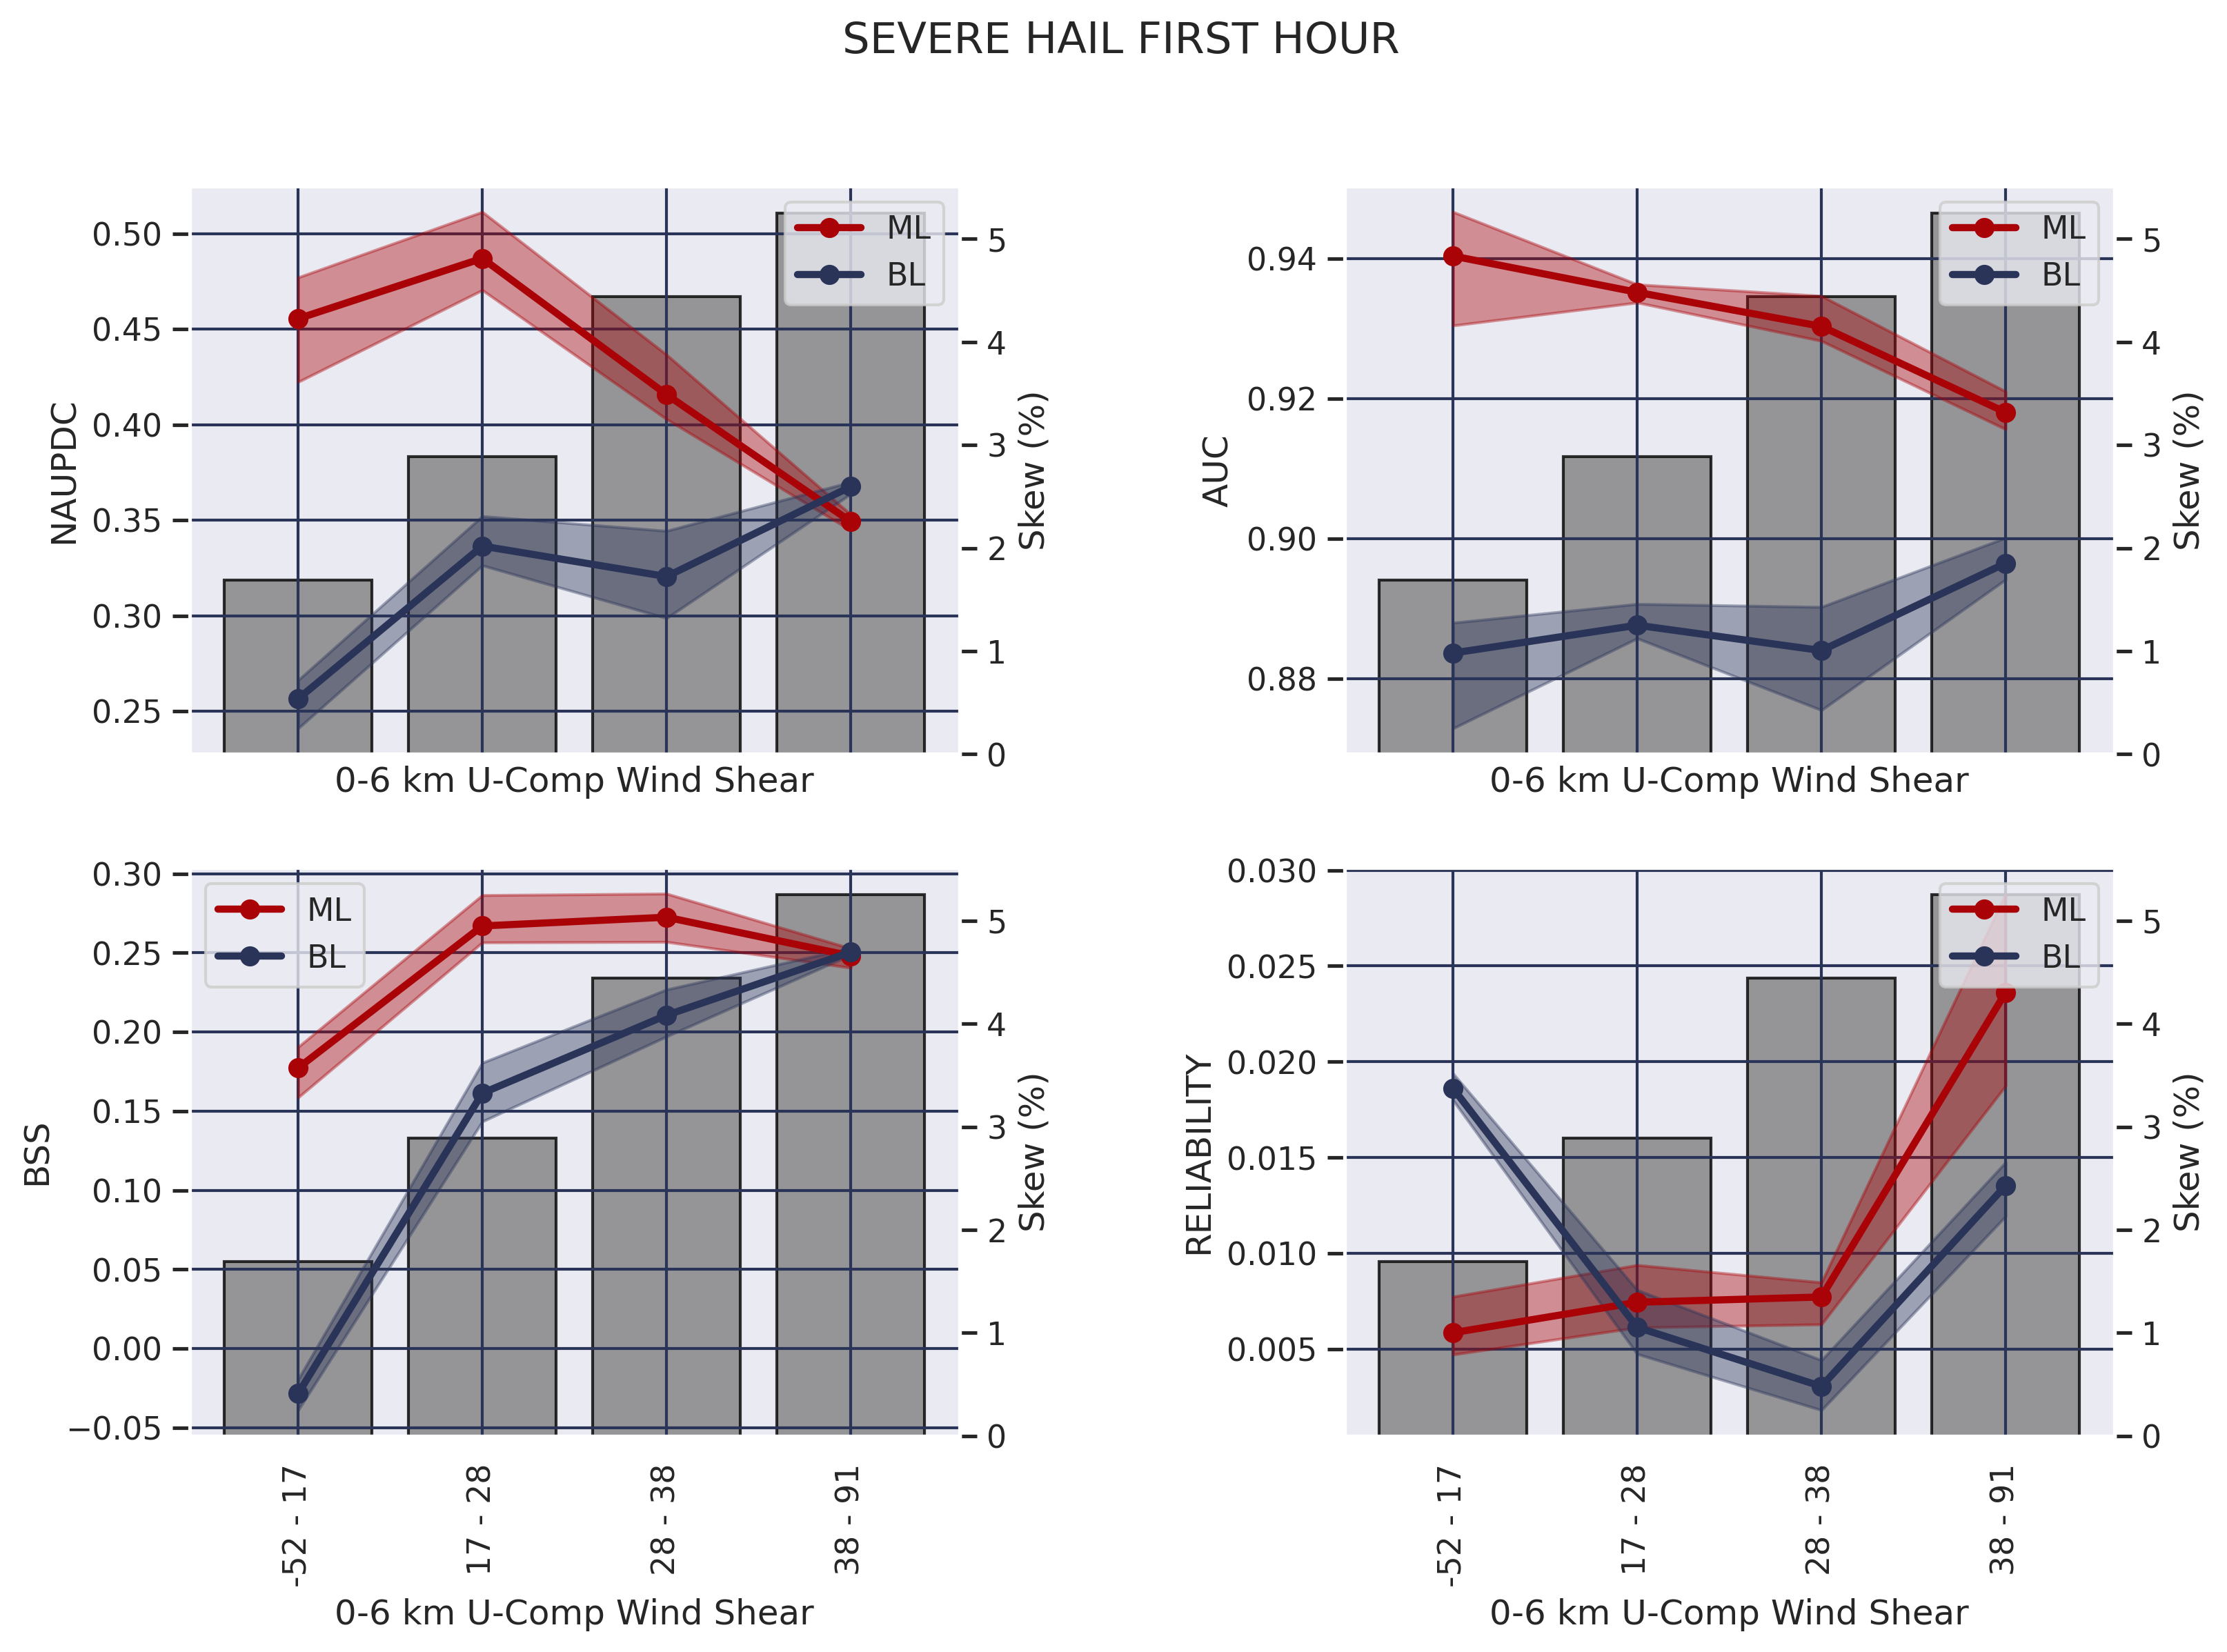

In [12]:
f,axes=plt.subplots(ncols=2, nrows=2, dpi=300, figsize=(12,8), sharex=True)
metrics = ['naupdc', 'auc', 'bss', 'reliability']
xdata = [0.5+i for i in range(n_bins-1)]
for ax, metric in zip(axes.flat, metrics):
    data = {'ML' : ml_ds[metric], 'BL' : bl_ds[metric]}
    pretty_plot(ax, xdata, data, 
                histdata=np.mean(ml_ds['Skew'].values, axis=1)*100., 
                hist_xdata = list(left_edges) + [np.max(variable)],
                xlabel='0-6 km U-Comp Wind Shear', 
                ylabel=metric.upper(), 
                right_ylabel = 'Skew (%)',
                model_name='', 
             )
    
plt.subplots_adjust(wspace=0.5, hspace=0.2)
plt.suptitle(f"{target.replace('_', ' ').upper()} {lead_time.replace('_', ' ').upper()}", fontsize=15)

## Initialization Time Stratification

In [13]:
# Group Initialization times into overlapping hour periods (e.g., 2100-2200, 2200-2300, )
times_iterator = ['2000', '2030', '2100', '2130', '2200',
       '2230', '2300', '2330','0000', '0030', '0100', '0130', '0200', '0230', '0300',]
group = []
for i in range(len(times_iterator)-2):
    if i%2==0:
        group.append(list(times_iterator[i+d] for d in range(3)))

xdata_init_times=[]
for g in group:
    first_time = g[0][:2]+':'+g[0][2:]
    second_time = g[-1][:2]+':'+g[-1][2:]
    xdata_init_times.append(f'{first_time} - {second_time}')

In [15]:
# Stratify by initialization times 
ml_ds, bl_ds = data_iterator(to_be_stratified=init_times, 
                             iterator=group,
                             ml_predictions=ml_predictions,
                             bl_predictions=bl_predictions,
                             forecast_time_indices = test_df['FCST_TIME_IDX'].astype(int),
                             X=test_df,
                             y=y,
                             known_skew=known_skew[lead_time][target],
                             n_bootstrap=n_bootstrap,
                            )

# Save the results
# ml_ds.to_netcdf(filename)
# bl_ds.to_netcdf(filename)

Text(0.5, 0.98, 'SEVERE HAIL FIRST HOUR')

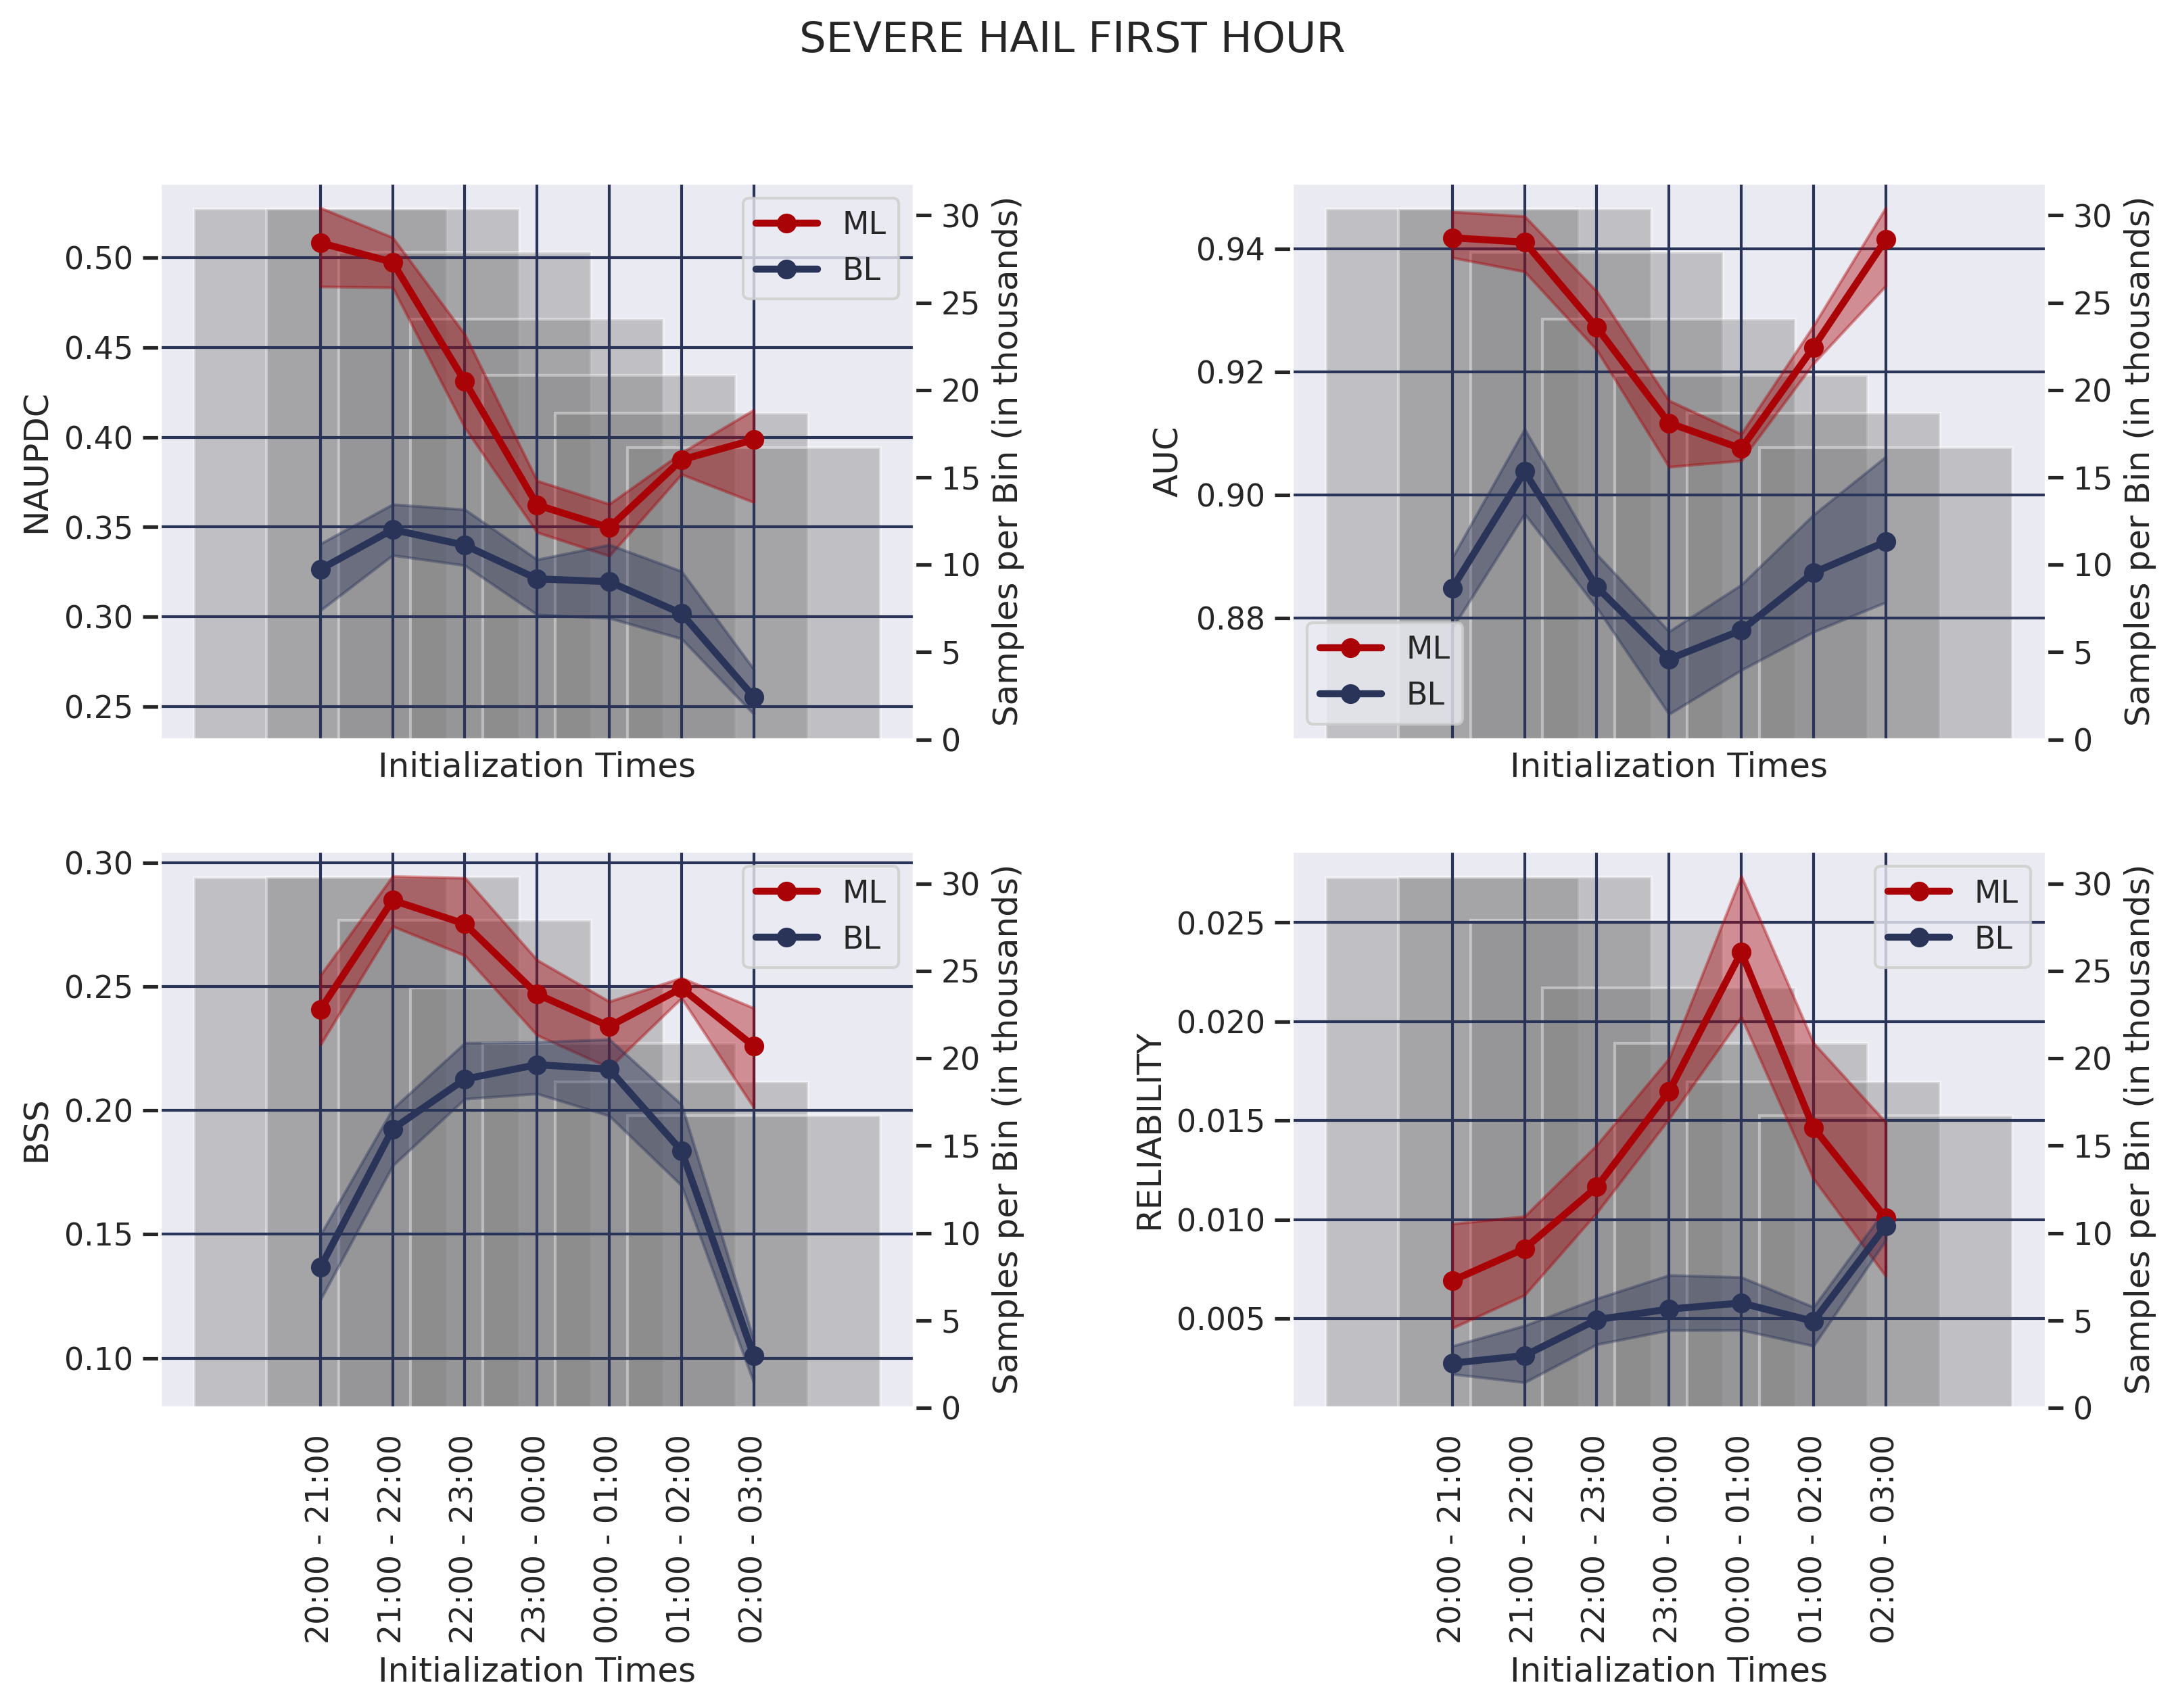

In [16]:
f,axes=plt.subplots(ncols=2, nrows=2, dpi=300, figsize=(12,8), sharex=True)
metrics = ['naupdc', 'auc', 'bss', 'reliability']

for ax, metric in zip(axes.flat, metrics):
    data = {'ML' : ml_ds[metric], 'BL' : bl_ds[metric]}
    
    pretty_plot(ax, xdata_init_times, data, 
                histdata=np.mean(ml_ds['Counts'].values, axis=1).astype(int)/1000, 
                xlabel='Initialization Times', 
                ylabel=metric.upper(), 
                right_ylabel = 'Samples per Bin (in thousands)',
                model_name='')
    
plt.subplots_adjust(wspace=0.5, hspace=0.2)
plt.suptitle(f"{target.replace('_', ' ').upper()} {lead_time.replace('_', ' ').upper()}", fontsize=15)

In [ ]:
f,axes=plt.subplots(ncols=2, nrows=2, dpi=300, figsize=(12,8), sharex=True)
metrics = ['naupdc', 'auc', 'bss', 'reliability']

for ax, metric in zip(axes.flat, metrics):
    data = {'ML' : ml_ds[metric], 'BL' : bl_ds[metric]}
    
    pretty_plot(ax, xdata_init_times, data, 
                histdata=np.mean(ml_ds['Skew'].values, axis=1)*100., 
                xlabel='Initialization Times', 
                ylabel=metric.upper(), 
                right_ylabel = 'Skew (%)',
                model_name='')
    
plt.subplots_adjust(wspace=0.5, hspace=0.2)
plt.suptitle(f"{target.replace('_', ' ').upper()} {lead_time.replace('_', ' ').upper()}", fontsize=15)

In [ ]:
f,axes=plt.subplots(ncols=2, nrows=2, dpi=300, figsize=(12,8), sharex=True)
metrics = ['naupdc', 'auc', 'bss', 'reliability']

for ax, metric in zip(axes.flat, metrics):
    data = {'ML' : ml_ds[metric], 'BL' : bl_ds[metric]}
    
    pretty_plot(ax, xdata_init_times, data, 
                histdata=np.mean(ml_ds['Day Counts'].values, axis=1)*100., 
                xlabel='Initialization Times', 
                ylabel=metric.upper(), 
                right_ylabel = 'Percent of Days within Bin (%)',
                model_name='')
    
plt.subplots_adjust(wspace=0.5, hspace=0.2)
plt.suptitle(f"{target.replace('_', ' ').upper()} {lead_time.replace('_', ' ').upper()}", fontsize=15)

## Forecast Lead Time Stratification 

In [ ]:
# Stratify by forecast lead time
fcst_time_idx = test_df['FCST_TIME_IDX']
unique_fcst_time_idx = np.unique(fcst_time_idx)

ml_ds_lead_time, bl_ds_lead_time = data_iterator(to_be_stratified=fcst_time_idx, 
                             iterator=unique_fcst_time_idx,
                             ml_predictions=ml_predictions,
                             bl_predictions=bl_predictions,
                             X=test_df,
                             y=y,
                             known_skew=known_skew,
                             n_bootstrap=n_bootstrap,
                            )

In [ ]:
f,axes=plt.subplots(ncols=2, nrows=2, dpi=300, figsize=(12,8), sharex=True)

for ax, metric in zip(axes.flat, metrics):
    data = {'ML' : ml_ds_lead_time[metric], 'BL' : bl_ds_lead_time[metric]}
    
    pretty_plot(ax, unique_fcst_time_idx*5, data, 
            histdata=np.mean(ml_ds_lead_time['Counts'].values, axis=1).astype(int)/1000, 
                xlabel='Forecast Lead Time (min)', 
                ylabel=metric.upper(), 
                right_ylabel = 'Samples per Bin (in thousands)',
                model_name='')
    
plt.subplots_adjust(wspace=0.5, hspace=0.2)
plt.suptitle(f"{target.replace('_', ' ').upper()} {lead_time.replace('_', ' ').upper()}", fontsize=15)

## Geographic Region Stratification 

In [ ]:
wofs_domain = pd.read_pickle('wofs_domains.pkl').astype(int)
cent_lon = wofs_domain['cent_lon']
cent_lat = wofs_domain['cent_lat']
all_wofs_dates = wofs_domain['dates']

In [ ]:
import collections
east_west_divider = np.where(np.round(cent_lon,5) <= -90.0, 'west', 'east')
north_south_divider = np.where(np.round(cent_lat,5) >= 37.0, 'north', 'south')
divider = np.array([f'{a}_{b}' for a,b in zip(north_south_divider, east_west_divider)], dtype='object')

geography = np.zeros((len(test_df)), dtype='object')
for a,b in itertools.product(['north', 'south'], ['east', 'west']):
    cardinality = f'{a}_{b}'
    date_subset = list(all_wofs_dates[divider==cardinality])
    geography[test_dates.astype(int).isin((date_subset))] = cardinality

In [ ]:
iterator = ['Northern Great Plains', 'Mid-Atlantic', 'Southern Great Plains', 'South East']
mapper = {'north_west' : 'Northern Great Plains', 
          'north_east' : 'Mid-Atlantic', 
          'south_west' : 'Southern Great Plains', 
          'south_east' : 'South East'
         }
geography = np.array([mapper[item] for item in geography], dtype='object')

In [ ]:
# Stratify by initialization times 
ml_ds_geo, bl_ds_geo = data_iterator(to_be_stratified=geography, 
                             iterator=iterator,
                             ml_predictions=ml_predictions,
                             bl_predictions=bl_predictions,
                             forecast_time_indices = test_df['FCST_TIME_IDX'].astype(int), 
                             X=test_df, 
                             y=y,
                             known_skew=known_skew,
                             n_bootstrap=n_bootstrap,
                            )

In [ ]:
f,axes=plt.subplots(ncols=2, nrows=2, dpi=300, figsize=(12,8), sharex=True)

for ax, metric in zip(axes.flat, metrics):
    data = {'ML' : ml_ds_geo[metric], 'BL' : bl_ds_geo[metric]}
    
    pretty_plot(ax, iterator, data, 
            histdata=np.mean(ml_ds_geo['Counts'].values, axis=1).astype(int)/1000, 
                xlabel='', 
                ylabel=metric.upper(), 
                right_ylabel = 'Samples per Bin (in thousands)',
                model_name='', 
               scatter=True)
    
plt.subplots_adjust(wspace=0.3, hspace=0.2)
plt.suptitle(f"{target.replace('_', ' ').upper()} {lead_time.replace('_', ' ').upper()}", fontsize=15)

In [ ]:
f,axes=plt.subplots(ncols=2, nrows=2, dpi=300, figsize=(12,8), sharex=True)

for ax, metric in zip(axes.flat, metrics):
    data = {'ML' : ml_ds_geo[metric], 'BL' : bl_ds_geo[metric]}
    
    pretty_plot(ax, iterator, data, 
            histdata=np.mean(ml_ds_geo['Skew'].values, axis=1)*100, 
                xlabel='', 
                ylabel=metric.upper(), 
                right_ylabel = 'Skew (%)',
                model_name='', 
               scatter=True)
    
plt.subplots_adjust(wspace=0.3, hspace=0.2)
plt.suptitle(f"{target.replace('_', ' ').upper()} {lead_time.replace('_', ' ').upper()}", fontsize=15)

In [ ]:
f,axes=plt.subplots(ncols=2, nrows=2, dpi=300, figsize=(12,8), sharex=True)

for ax, metric in zip(axes.flat, metrics):
    data = {'ML' : ml_ds_geo[metric], 'BL' : bl_ds_geo[metric]}
    
    pretty_plot(ax, iterator, data, 
            histdata=np.mean(ml_ds_geo['Day Counts'].values, axis=1)*100., 
                xlabel='', 
                ylabel=metric.upper(), 
                right_ylabel = 'Percent of Days Within Bins (%)',
                model_name='', 
               scatter=True)
    
plt.subplots_adjust(wspace=0.3, hspace=0.2)
plt.suptitle(f"{target.replace('_', ' ').upper()} {lead_time.replace('_', ' ').upper()}", fontsize=15)

# Evaluate CAPE-SHEAR Space 

In [ ]:
shear = np.sqrt(X['shear_u_0to6_ens_mean_spatial_mean']**2 + X['shear_v_0to6_ens_mean_spatial_mean']**2)

In [ ]:
n_bootstrap = 100

iterator_x = [0, 500]
iterator_y = [0, 10,]

ml_results, bl_results = data_iterator_2d(to_be_stratified_x=X['cape_ml_ens_mean_spatial_mean'],
                 to_be_stratified_y=shear,
                  iterator_x=iterator_x,
                  iterator_y=iterator_y,
                  n_bins=2,
                  ml_predictions=ml_predictions, 
                  bl_predictions=bl_predictions,
                  X=test_df,
                  y=y, 
                  known_skew=known_skew,
                  n_bootstrap=n_bootstrap, 
                )

In [ ]:
f,axes=plt.subplots(ncols=3, nrows=2, dpi=550, figsize=(10,4), sharex=True, sharey=True)
metrics = ['naupdc', 'auc', 'bss', ]

i=0
for ax, metric in zip(axes.flat, metrics*2):
    if i > len(metrics)-1:
        data = {'BL' : bl_results[metric],}
    else:
        data = {'ML' : ml_results[metric],}
    pretty_plot(ax, x=iterator_x, 
                y=iterator_y, 
                data=data, 
                histdata=np.mean(ml_ds['Counts'].values, axis=1).astype(int)/1000, 
                xlabel='Mixed-Layer CAPE', 
                ylabel='0-6 km Wind Shear', 
                right_ylabel = 'Samples per Bin (in thousands)',
                metric=metric.upper())
    i+=1
    
plt.subplots_adjust(wspace=0.4, hspace=0.3)
plt.suptitle(f"{target.replace('_', ' ').upper()} {lead_time.replace('_', ' ').upper()}", fontsize=15)

f.text(0.5, -0.08, 'Mixed-Layer CAPE', ha='center', fontsize=15)
f.text(0.04, 0.5, '0-6 km Wind Shear', va='center', rotation='vertical', fontsize=15)
